# Variational Autoencoders
 - Models latent space
 - by taking the STD and MEAN of encoder
   sampling from gaussian distribution of encoder STD
   adding samples to MEAN
   thus generating a representation of the latent space
 - before decoding again like a standard Autoencoder
 
 Source: 
 https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [4]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [69]:
x = np.array([-1.2, 0.1, 0.8, 2.1, 3.3, 3.7, 4.8, 6.2, 7.4, 7.9, 9.2, 10.1,
              11.2, 12.1, 13.1, 14.0, 14.9, 15.1, 15.8, 17.2, 18.1, 19.2, 20.0,
              21.1, 22.1, 23.2, 23.8, 24.9, 26.4, 26.8, 28.0, 29.1, 30.1,
              31.2, 32.1, 33.1, 34.0, 34.9, 35.1, 35.8, 37.2, 38.1, 39.2, 40.0,
              41.1, 42.1, 43.2, 43.8, 44.9, 46.4, 46.8, 48.0, 49.1, 50.1,
              
              51.2, 52.1, 53.1, 54.0, 54.9, 55.1, 55.8, 57.2, 58.1, 59.2, 60.0,
              61.1, 62.1, 63.2, 63.8, 64.9, 66.4, 66.8, 68.0, 69.1, 70.1,
              71.2, 72.1, 73.1, 74.0, 74.9, 75.1, 75.8, 77.2, 78.1, 79.2, 80.0,
              81.1, 82.1, 83.2, 83.8, 84.9, 86.4, 86.8, 88.0, 89.1, 90.1,
              
              91.2, 92.1, 93.1, 94.0, 94.9, 95.1, 95.8, 97.2, 98.1, 99.2, 100.0,
              101.1, 102.1, 103.2, 103.8, 104.9, 106.4, 106.8, 108.0, 109.1, 110.1,
              
             ], dtype=float)
x_anomaly = np.array([-1.1, 0.1, 0.9, 2.1, 3.1, 3.8, 15.2, 6.1, 6.9, 7.8, 9.3, 10.0], dtype=float)

In [70]:
df = pd.DataFrame(x)
df_anomaly = pd.DataFrame(x_anomaly)

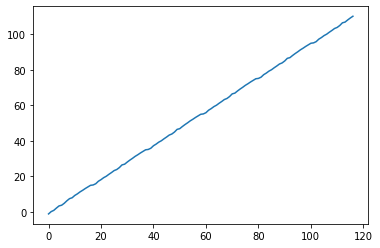

In [71]:
fig, ax = plt.subplots()
df.plot(legend=False, ax=ax)
plt.show()

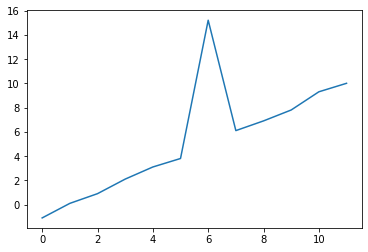

In [72]:
fig, ax = plt.subplots()
df_anomaly.plot(legend=False, ax=ax)
plt.show()

# Aim: 
- Detect the anomaly in df_anomaly with an auto encoder

In [73]:
training_mean = df.mean()
training_std = df.std()
df_training_value = (df - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 117


In [74]:
TIME_STEPS = 4

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [75]:
x_train = create_sequences(df.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (114, 4, 1)


# Build model
- Build a convolutional reconstruction autoencoder model. 
- The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape.

In [76]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 2, 32)             256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             3600      
_________________________________________________________________
conv1d_transpose_12 (Conv1DT (None, 2, 16)             1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 16)             0         
_________________________________________________________________
conv1d_transpose_13 (Conv1DT (None, 4, 32)             3616      
_________________________________________________________________
conv1d_transpose_14 (Conv1DT (None, 4, 1)             

In [77]:
history = model.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=2,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

Epoch 1/10
51/51 [==============================] - 1s 4ms/step - loss: 2306.2869 - val_loss: 541.4405
Epoch 2/10
51/51 [==============================] - 0s 2ms/step - loss: 119.6459 - val_loss: 6.7355
Epoch 3/10
51/51 [==============================] - 0s 2ms/step - loss: 118.3467 - val_loss: 45.3104
Epoch 4/10
51/51 [==============================] - 0s 2ms/step - loss: 134.2884 - val_loss: 148.2701
Epoch 5/10
51/51 [==============================] - 0s 1ms/step - loss: 94.6677 - val_loss: 302.2665
Epoch 6/10
51/51 [==============================] - 0s 2ms/step - loss: 63.3911 - val_loss: 1.5971
Epoch 7/10
51/51 [==============================] - 0s 3ms/step - loss: 68.3200 - val_loss: 0.5284
Epoch 8/10
51/51 [==============================] - 0s 2ms/step - loss: 169.4195 - val_loss: 36.5531
Epoch 9/10
51/51 [==============================] - 0s 3ms/step - loss: 143.5539 - val_loss: 3.7174
Epoch 10/10
51/51 [==============================] - 0s 2ms/step - loss: 88.6047 - val_loss: 1

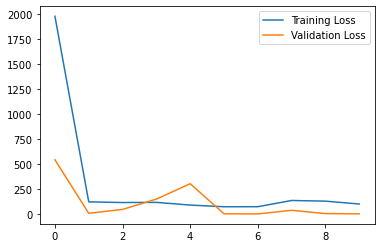

In [78]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct the input data.

- Find MAE loss on training samples.
- Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
- If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

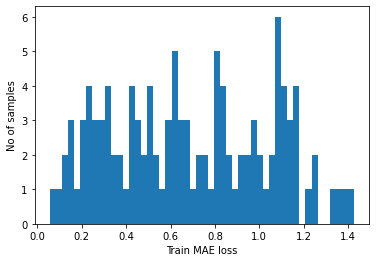

Reconstruction error threshold:  1.4272016763687134


In [79]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

# Compare recontruction
Check how model has recontructed the 100th sample. 

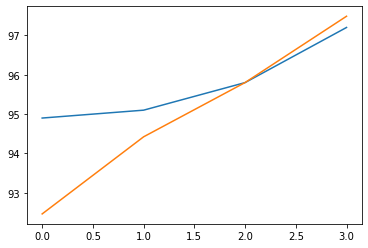

In [82]:
# Checking how the first sequence is learnt
plt.plot(x_train[100])
plt.plot(x_train_pred[100])
plt.show()

# Prepare Test Data

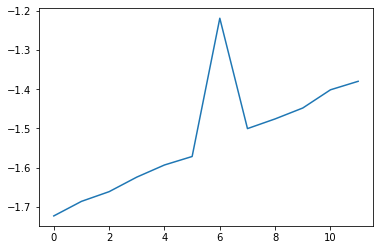

In [83]:
df_test_value = (df_anomaly - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [84]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

Test input shape:  (9, 4, 1)


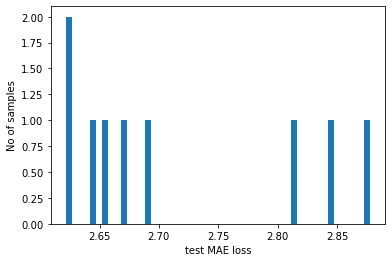

Number of anomaly samples:  9
Indices of anomaly samples:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8]),)


In [85]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

# Plot anomalies

In [86]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

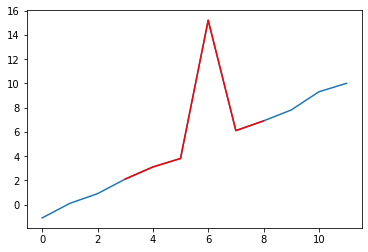

In [89]:
df_subset = df_anomaly.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()